# XML2MySQL

Data from stackexchange dump comes in .xml format and must be loaded into a MySQL database to make working with the data easier.

## .xml Source File

The raw data from stackexchange was dumped in .xml format

See sample below:

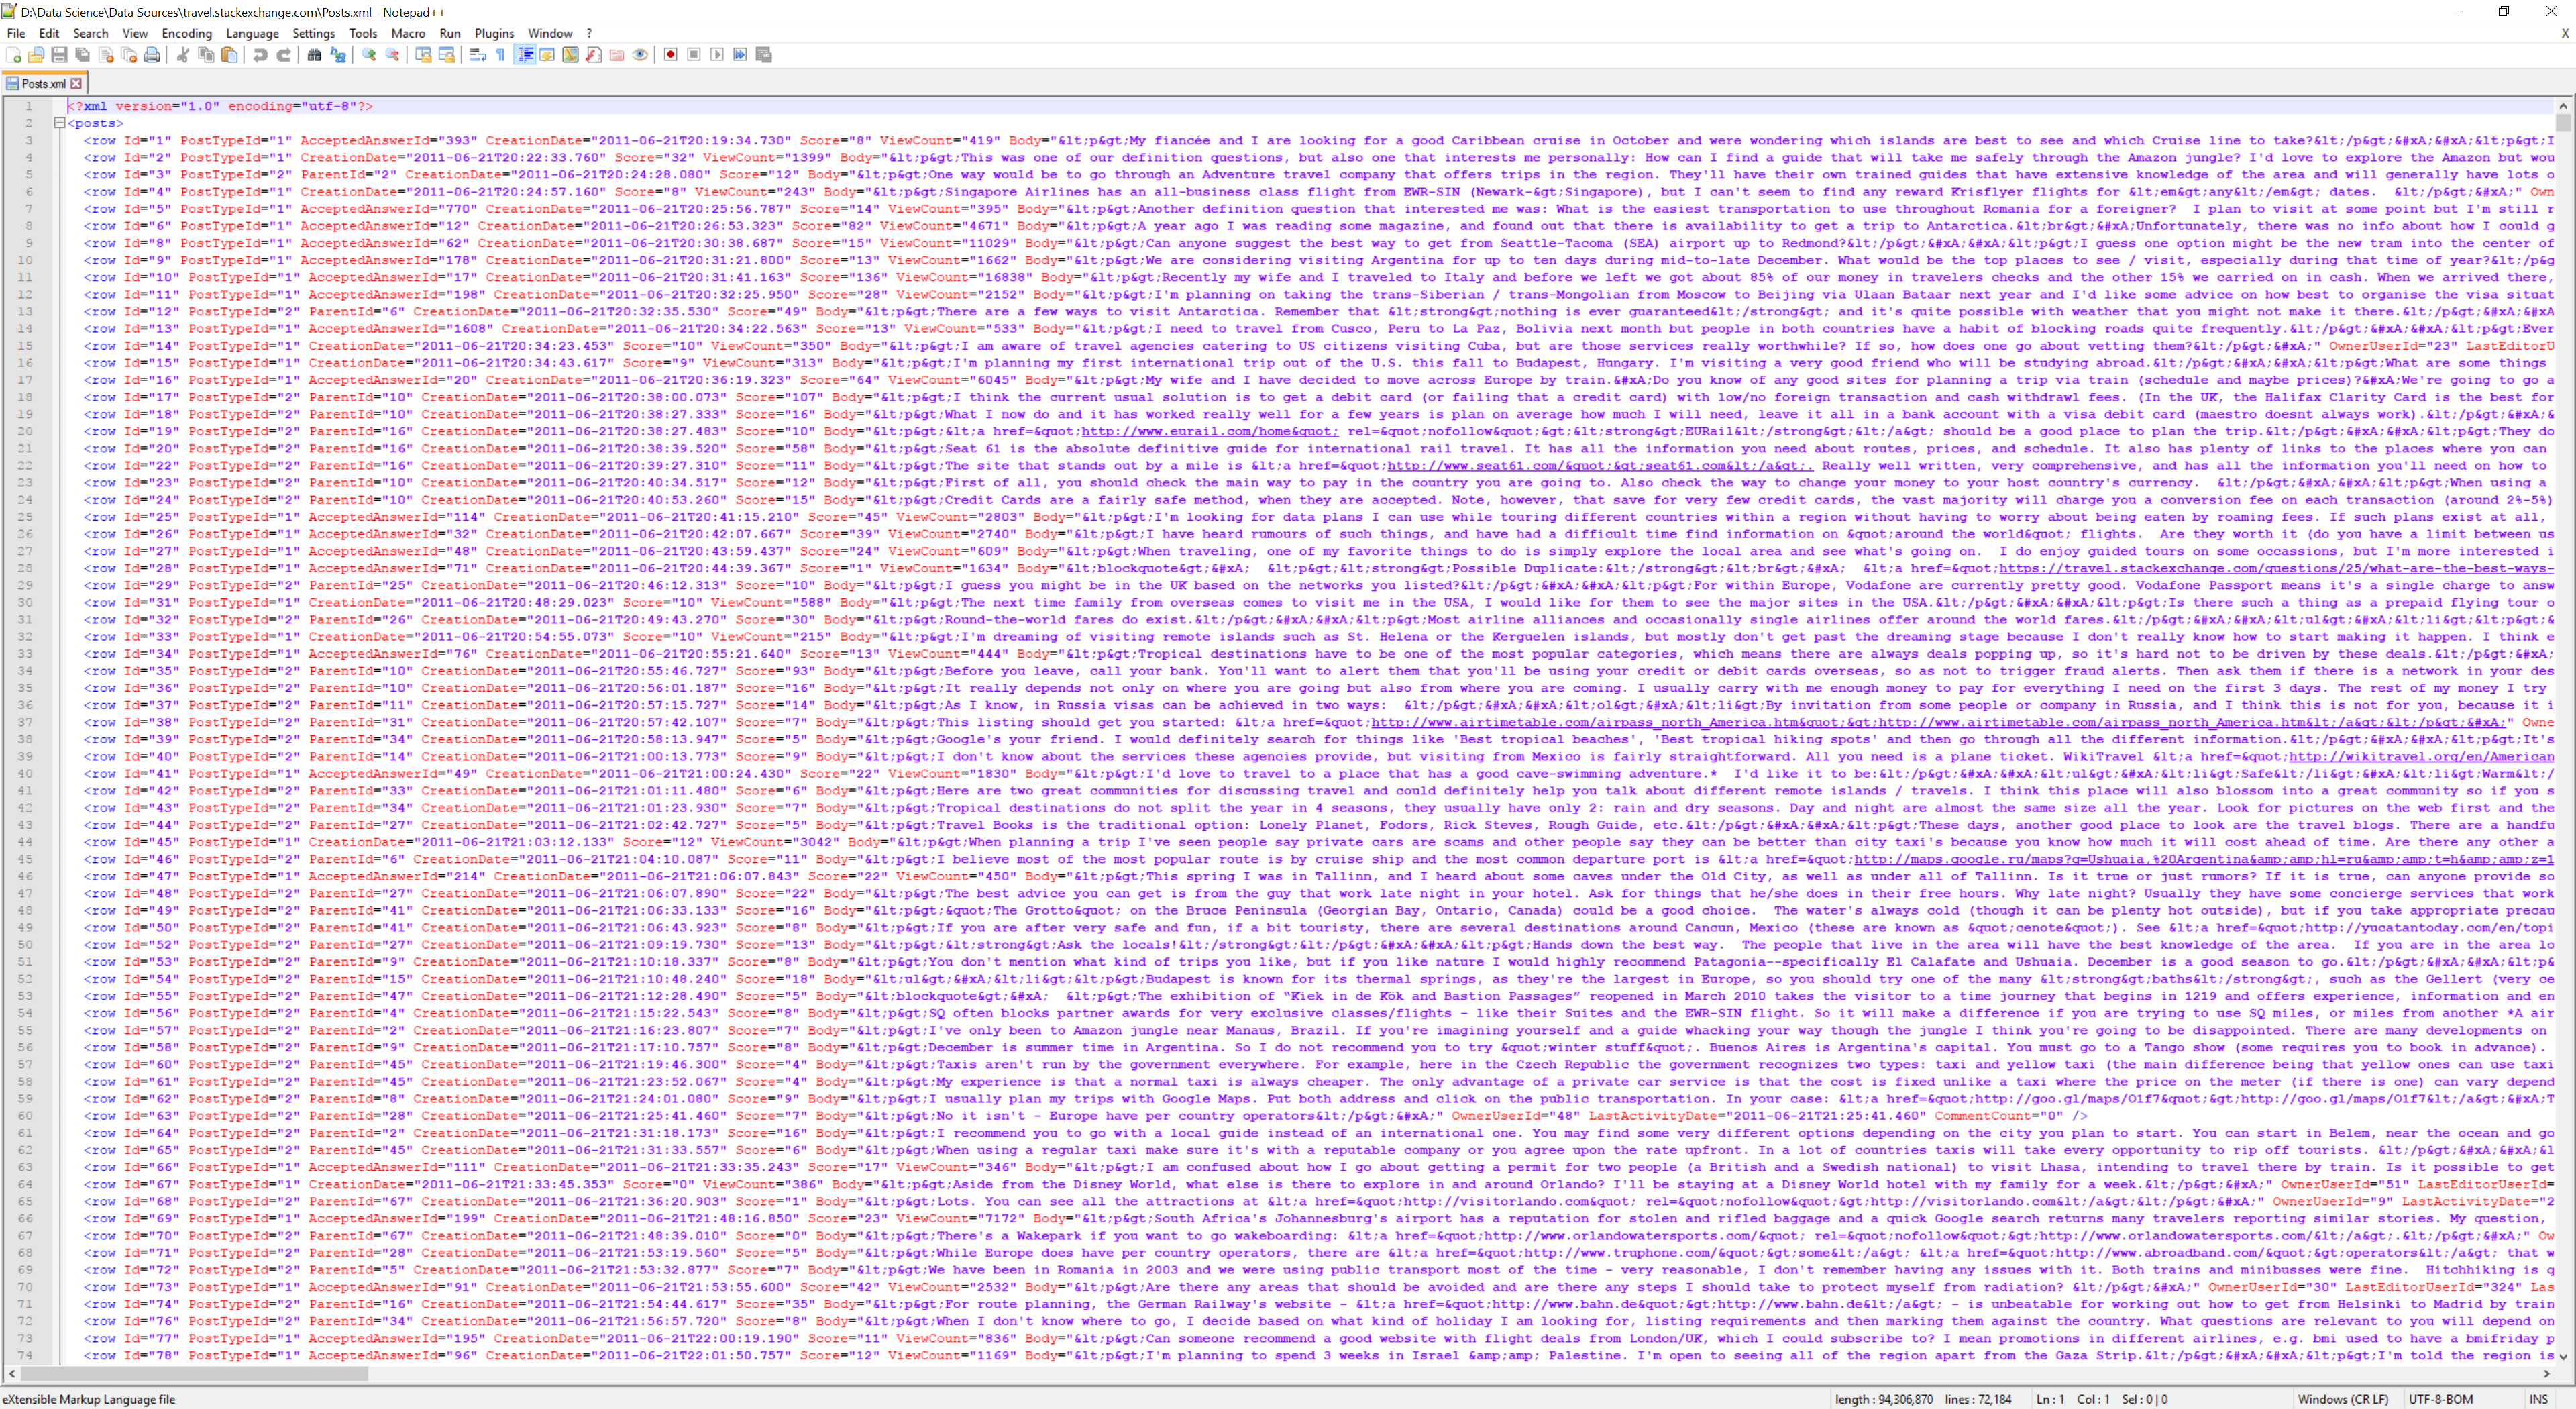

In [1]:
from IPython.display import Image
Image(filename='Sample XML File.PNG')

In [2]:
# Title: .xml to MySQL transformation
# Author: Travis Jefferies
# Date: 11/12/17
# Code Version: 1.0
# Availability: 

import xml.etree.ElementTree as ET
from sqlalchemy import create_engine
import sys
import pandas as pd
from mysql.connector import MySQLConnection, Error
from glob import glob
from os import path
from collections import defaultdict

def get_xml_files(path):
    """ Takes a path as input and globs all .xml files in path 
        Returns a list of .xml file paths """
    file_paths = list()
    for file in glob(path+'*'):
        file_paths.append(str(path)+str(file.split('\\')[1]))
    return file_paths

def connect(localhost,database,user,password):
    """ Connect to MySQL database
        Connection remains open 
        Returns MySQL db connection """
    try:
        conn = create_engine("mysql+mysqlconnector://"+user+':'+password+"@"+localhost+"/"+database)
    except:
        conn = False
    if conn:
        print('Connected to MySQL database')
    return conn

class xml_to_mysql:
    
    def __init__(self, path_to_xml_file,db_connection,table_name):
        try:
            self.path = path_to_xml_file
        except IOError:
            input('Please enter valid .xml file path. Press any key to close program.')
            sys.exit()
        try:
            self.conn = db_connection
        except:
            input('Please enter valid MySQL database connection object. Press any key to close program.')
            sys.exit()
        self.tree = ET.parse(self.path)
        self.root = self.tree.getroot()
        self.table = table_name
        self.df = pd.DataFrame()
        
    def xml2mysql(self):
        """ Finds root.children.attributes {tag: text}
            loops through grabbing data in row structure
            creates new table in database
            with records that use row inherited schema 
            or
            replaces existing table records
            depending on table exists status """
        root = self.root
        all_dummies = []
        for i, child in enumerate(root):
            dummy = {}
            for attr,value in child.attrib.items():
                dummy[attr] = value
            all_dummies.append(dummy)
        self.df = pd.DataFrame(all_dummies).drop_duplicates()
        self.df.to_sql(con=self.conn,name=self.table,if_exists='replace')
        df = self.df
        return df
        
def main():
    """ Takes a directory containing .xml files as input
        parses .xml
        creates new tables in existing MySQL database
        using parsed .xml data """

    """ connect() :params:   localhost := host_server Ex: 'localhost'
                             database := target_database Ex: 'dvdrentals'
                             user := username  Ex: 'root'
                             password := password 'mypassworddadada'
                             
                  :return:   MySQL DB connection """
    
    """ get_xml_files() :params:   path := directory of .xml files to be pushed to MySQL                             
                        :return:   list of .xml file paths """
    
    xml_file_path = "C:/Users/jeffe/Downloads/travel.stackexchange.com/"
    try:
        connection = connect('localhost','stackexchange_travel','root',password)
#     update_max_allowed_packet(connection)
        dfs = list()
        split_paths = [path.split(p) for p in get_xml_files(xml_file_path)]
        for xml, table in zip(get_xml_files(xml_file_path),split_paths):
            x = xml_to_mysql(xml,connection,table[1].split('.')[0].lower())
            dfs.append(x)
        print('.xml files successfully entered into database.')
        return dfs
    except BaseException as e:
        print('Failed to do something: ' + str(e))
        input('Press any key to end program.')
if __name__ == '__main__':
    main()

Connected to MySQL database
.xml files successfully entered into database.


# Database Schema Rev 1

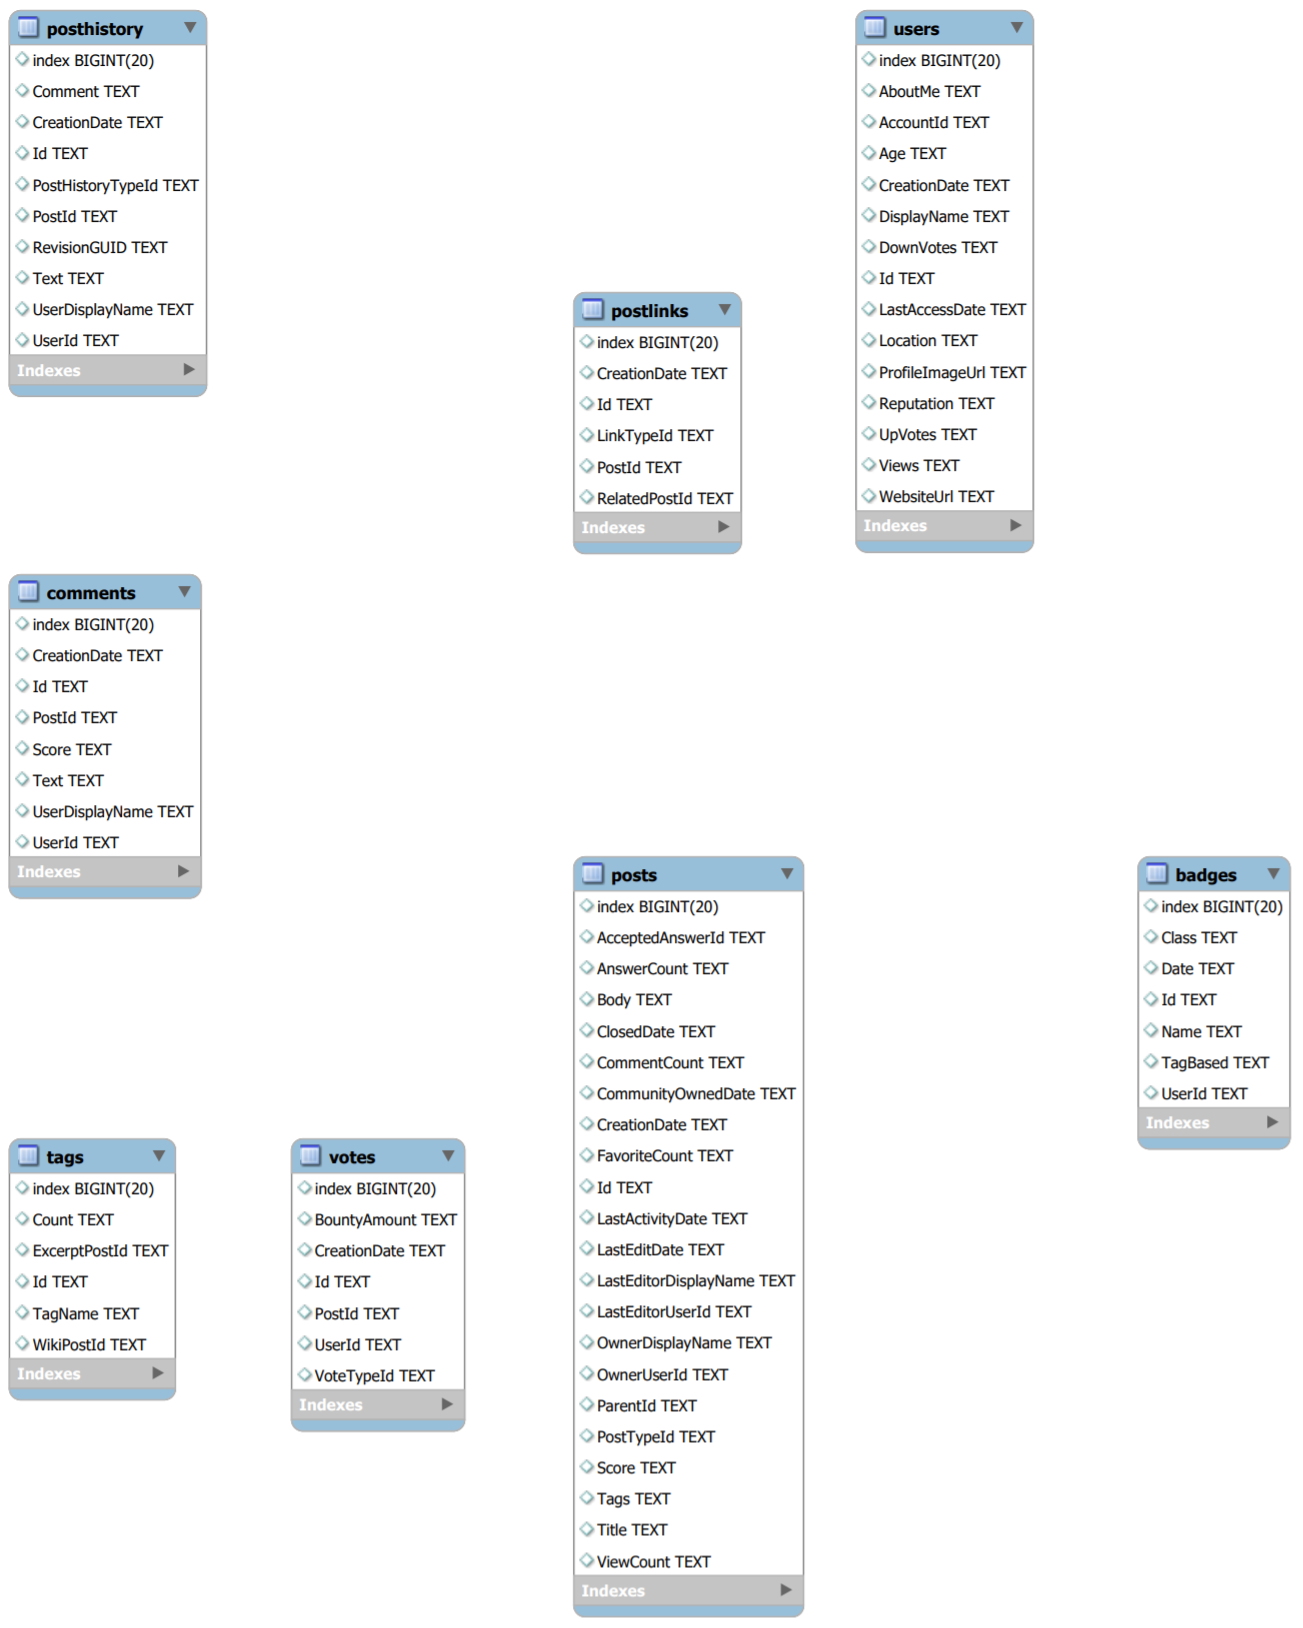

In [3]:
Image(filename='db_schema_1.PNG')

This doesn't do us much good as all of the data types have been defaulted to TEXT. Lets make a class that will allow us to generate a .sql script that will programmatically change data types.

## set_table_data_types class

In [10]:
class set_table_data_types:
    
    def __init__(self,host,db,user,password):
        """
        params:
                    localhost := host_server Ex: 'localhost'
                    database := target_database Ex: 'dvdrentals'
                    user := username  Ex: 'root'
                    password := password 'mypassworddadada'
                    
        return:
        """
        self.host = host
        self.db = db
        connection_string = 'mysql+mysqldb://'+user+':'+password+'@'+host+'/'+db
        self.query_connection = create_engine(connection_string)
        try:
            self.db_connection = MySQLConnection(
                                        host = host,
                                        database = db,
                                        user = user,
                                        password = password)
            if self.db_connection.is_connected():
                print('Connection to MySQL database ' + db + ' successful.')
        except Error:
            print('Error connecting to database ' + db)
            print(Error)
            
        self.columns = defaultdict(list)
    
    def change_column_datatype(self, column_data_type_mapping=None):
        """
        params:
        return:
        """
        alter_tbl_query = list()
        alter_tbl_query.append('USE '+self.db+';')
        alter_query_template = "ALTER TABLE {} MODIFY {} {}"
        try:
            cursor_alter_tables = self.db_connection.cursor()
            cursor_table_name = self.db_connection.cursor()
            cursor_table_name.execute("SHOW TABLES")
            table_names = cursor_table_name.fetchall()
            for table_name in table_names:
                tbl_name = table_name[0]
                cursor_column_names = self.db_connection.cursor()
                query = "SELECT * FROM information_schema.columns WHERE table_name= " + "'" + tbl_name + "'"
                cursor_column_names.execute(query)
                col_names = cursor_column_names.fetchall()
                for c_name in col_names:
                    self.columns[tbl_name].append(c_name[3])
                cursor_column_names.close()
            alter_query_template = "ALTER TABLE {} MODIFY {} {} ;"
            for tbl, cols in session.columns.items():
                for col in cols:
                    if col.lower() == 'date':
                        sql_syntax_col_name = '`'+col+'`'
                        column_type = 'DATETIME'
                    elif col.lower() == 'count':
                        sql_syntax_col_name = '`'+col+'`'
                        column_type = 'INT'
                    elif col.lower() == 'index':
                        sql_syntax_col_name = '`'+col+'`'
                        column_type = 'INT'
                    elif col.lower() == 'comment':
                        sql_syntax_col_name = '`'+col+'`'
                        column_type = 'TEXT'
                    elif col.lower() == 'revisionguid':
                        column_type = 'TEXT(100)'
                    else:
                        sql_syntax_col_name = col
                        if 'date' in col.lower():
                            column_type = 'DATETIME'
                        elif 'id' in col.lower():
                            column_type = 'INT'
                        elif 'vote' in col.lower():
                            column_type = 'INT'
                        elif 'count' in col.lower():
                            column_type = 'INT'
                        elif col.lower() in column_type_mapping.keys():
                            column_type = column_type_mapping[col.lower()]
                        else:
                            column_type = 'TEXT'
                    alter_tbl_query.append(alter_query_template.format(tbl.lower(),sql_syntax_col_name,column_type))
            print('SQL: \n')
            print('\n'.join(alter_tbl_query))
            print()
#             for result in cursor_alter_tables.execute('\n'.join(alter_tbl_query), multi=True):
#                 pass
            print('Table column types successfully changed.')
        finally:
            self.db_connection.commit()
            cursor_table_name.close()
            self.db_connection.close()
            self.db_connection.disconnect()

In [14]:
session = set_table_data_types(host = 'localhost', db = 'stackexchange_travel', user = 'root', password = password)

Connection to MySQL database stackexchange_travel successful.


In [12]:
column_type_mapping = {'age':'INT', 
                       'reputation':'INT', 
                       'index': 'INT', 
                       'class': 'INT',  
                       'score': 'INT',
                       'bountyamount': 'FLOAT'}
session.change_column_datatype(column_type_mapping)

SQL: 

USE stackexchange_travel;
ALTER TABLE badges MODIFY `index` INT ;
ALTER TABLE badges MODIFY class INT ;
ALTER TABLE badges MODIFY `Date` DATETIME ;
ALTER TABLE badges MODIFY id INT ;
ALTER TABLE badges MODIFY Name TEXT ;
ALTER TABLE badges MODIFY TagBased TEXT ;
ALTER TABLE badges MODIFY userId INT ;
ALTER TABLE comments MODIFY `index` INT ;
ALTER TABLE comments MODIFY CreationDate DATETIME ;
ALTER TABLE comments MODIFY Id INT ;
ALTER TABLE comments MODIFY PostId INT ;
ALTER TABLE comments MODIFY score INT ;
ALTER TABLE comments MODIFY Text TEXT ;
ALTER TABLE comments MODIFY UserDisplayName TEXT ;
ALTER TABLE comments MODIFY userId INT ;
ALTER TABLE posthistory MODIFY `index` INT ;
ALTER TABLE posthistory MODIFY `Comment` TEXT ;
ALTER TABLE posthistory MODIFY CreationDate DATETIME ;
ALTER TABLE posthistory MODIFY Id INT ;
ALTER TABLE posthistory MODIFY PostHistoryTypeId INT ;
ALTER TABLE posthistory MODIFY PostID INT ;
ALTER TABLE posthistory MODIFY PostID TEXT(100) ;
ALTER TABL

## Database Schema Rev2

Now lets examine the database schema

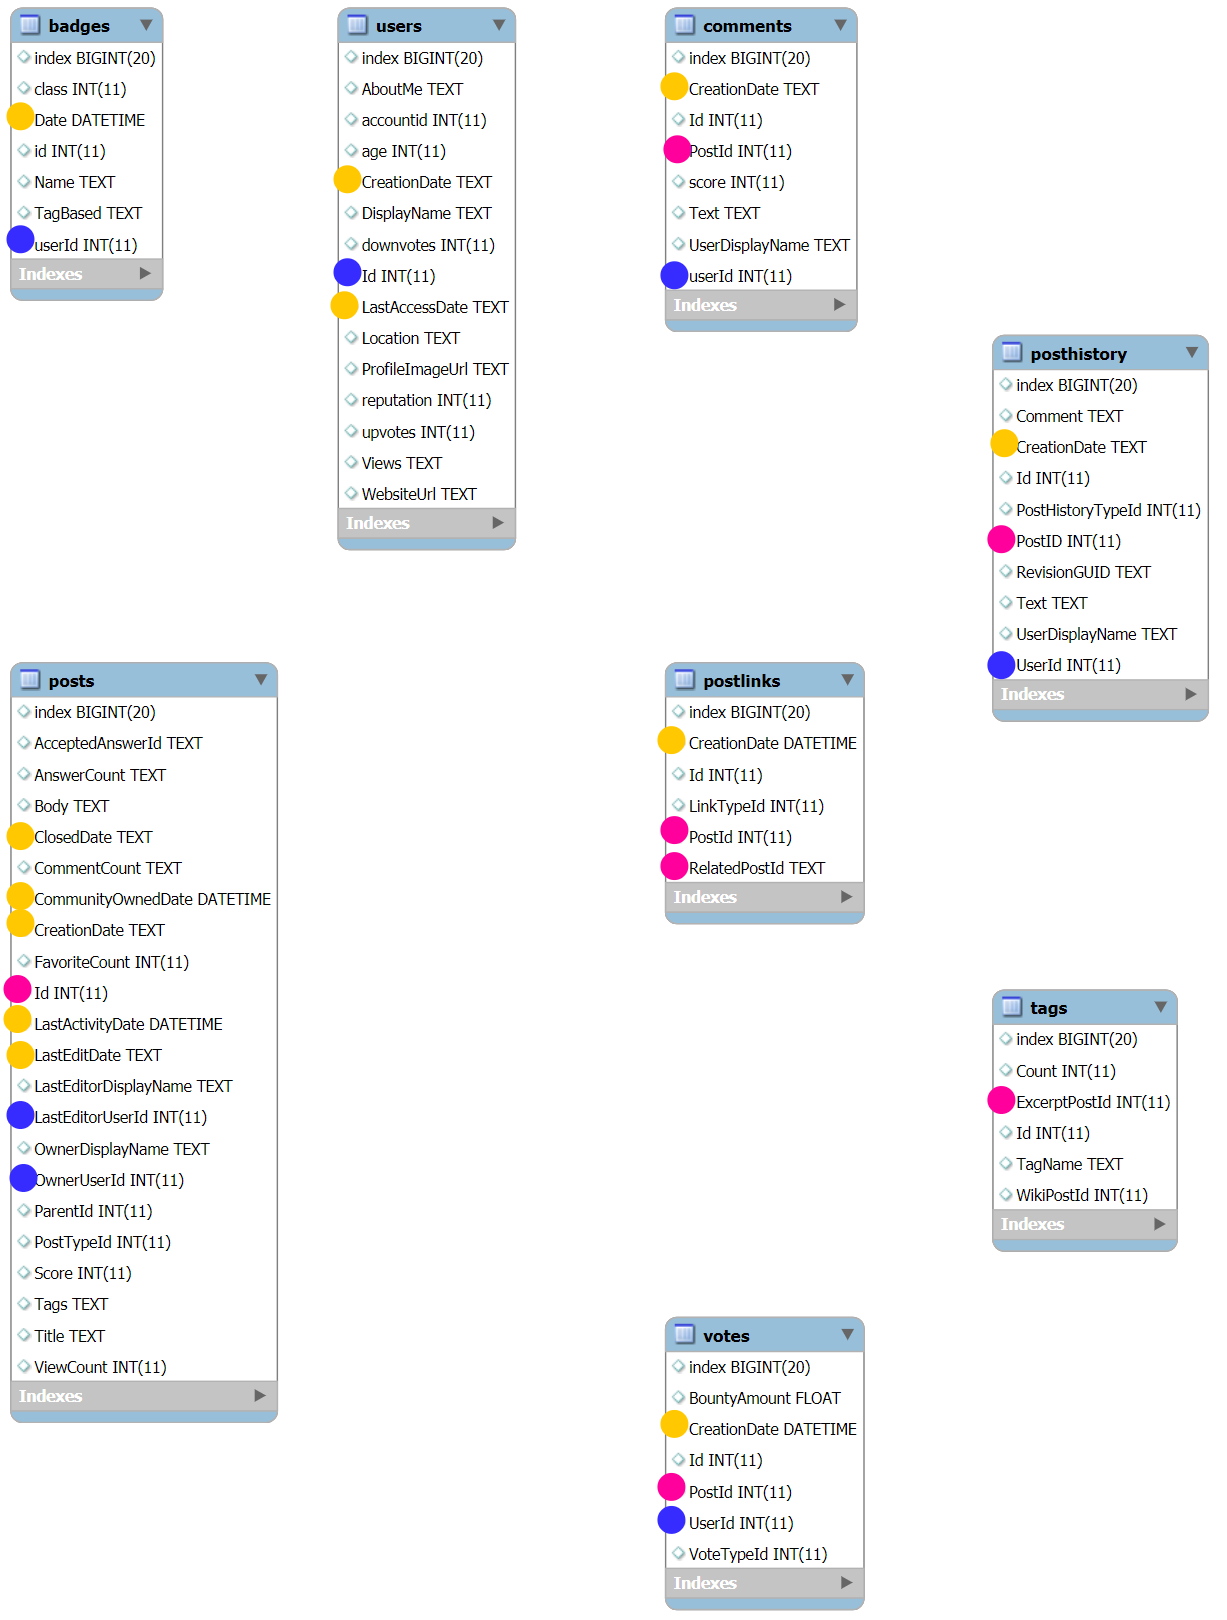

In [13]:
Image('db_schema_post_alter.PNG')